In [12]:
import pandas as pd
import json
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
%matplotlib inline

import psycopg2
import sys
import psycopg2.extras
from config import *
from textblob import TextBlob
import re

In [2]:
with open('artists.json', 'r') as f:
    artists = json.loads(f.read())

In [23]:
# read data into a list of dataframes then combine
dfs = []
for artist_name in artists.keys(): 
    genre = artists[artist_name]['info'][1]
    for album in artists[artist_name]['albums']: # a list of dictionaries
        album_name = list(album.keys())[0]
        df = pd.DataFrame.from_dict(album[album_name]).T
        df.columns = ['track_num', 'track_title', 'track_length', 'danceability', 'energy',
                      'tempo', 'speechiness', 'valence']
        df['artist'] = artist_name
        df['genre'] = genre
        dfs.append(df)

In [24]:
artist_df = pd.concat(dfs)
artist_df = artist_df.reset_index()

In [25]:
artist_df.head()

,index,track_num,track_title,track_length,danceability,energy,tempo,speechiness,valence,artist,genre
0,0996yf3TIgoHXnLehJhsPe,4,Best One - Remix,192294,0.404,0.823,74.356,0.0719,0.418,Anderson .Paak,deep indie r&b
1,0dwqEpmuc6QAMQtGhFC2us,6,Lyk Dis - Remix,133221,0.415,0.638,87.412,0.0551,0.755,Anderson .Paak,deep indie r&b
2,2JdbuanGl8mxzi8UEnkY7D,2,Livvin - Remix,103196,0.424,0.367,76.235,0.0638,0.138,Anderson .Paak,deep indie r&b
3,2sFuDKUkYPxh72X7moNJME,11,Suede - Uptwnmixx,137021,0.446,0.797,149.706,0.199,0.483,Anderson .Paak,deep indie r&b
4,2tJyUdxdjjAh5Y19e6DvzQ,8,H.A.N. - Remix,158250,0.334,0.615,98.135,0.208,0.62,Anderson .Paak,deep indie r&b


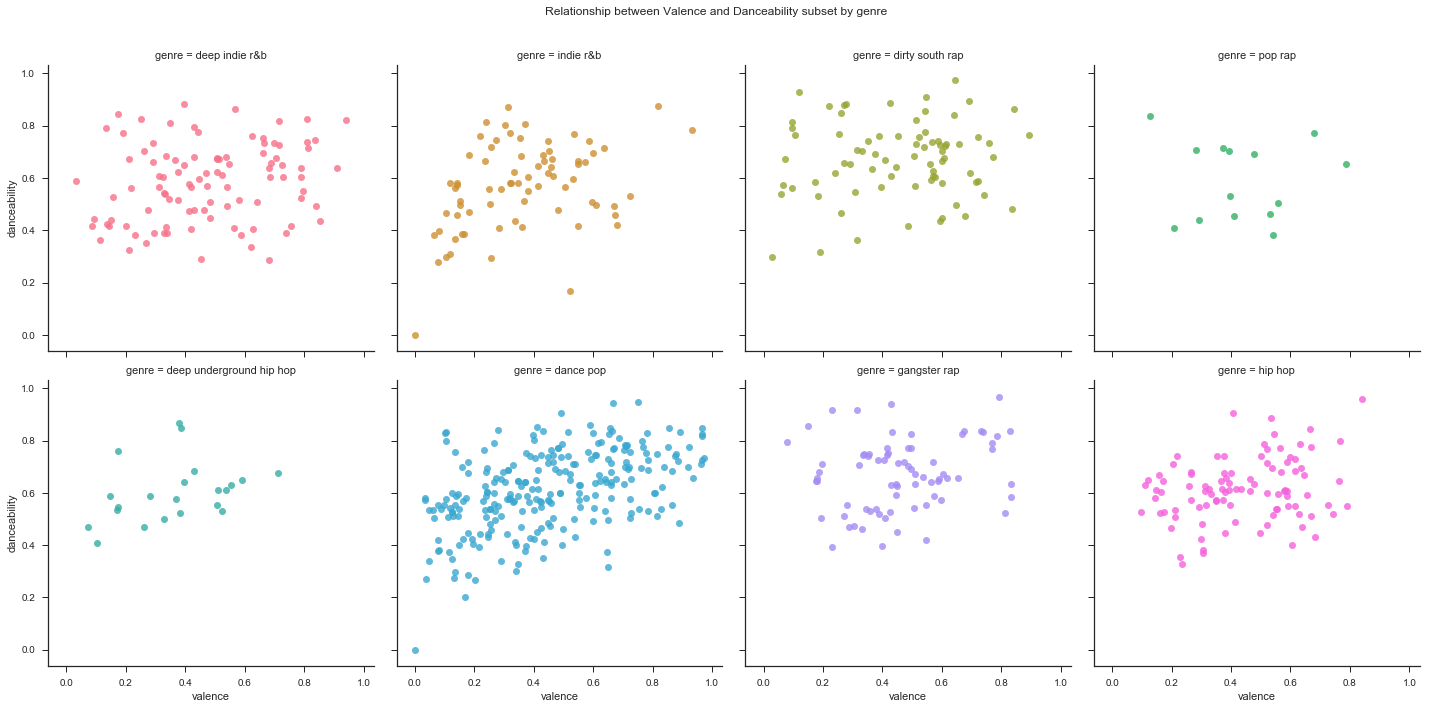

In [46]:
### Plot 1
plt_1 = sns.lmplot(x="valence", y="danceability", fit_reg=False, col='genre', col_wrap=4, hue='genre', data=artist_df);
plt.subplots_adjust(top=0.9)
plt_1.fig.suptitle("Relationship between Valence and Danceability subset by genre")
plt_1.savefig("plot_1.png")


# looking at lyrics

In [26]:
with open('songs.json', 'r') as f:
    songs = json.loads(f.read())

In [27]:
tagged_data = []
song_li = []
for artist in songs.keys():
    for song_id in songs[artist]:
        lyrics = songs[artist][song_id][0]
        tagged_data.append(TaggedDocument(words=word_tokenize(lyrics.lower()), tags=[song_id]))
        df = pd.DataFrame([artist, song_id, lyrics]).T
        df.columns = ['artist', 'song_id', 'lyrics']
        song_li.append(df)


In [28]:
song_df = pd.concat(song_li)

In [43]:
def get_lyrics_sentiment(lyrics):
    if lyrics is None:
        return -99
    blob = TextBlob(lyrics)
    return blob.sentiment.polarity

In [ ]:
song_df['lyrics_polarity'] = song_df.lyrics.apply(get_lyrics_sentiment)

In [32]:
max_epochs = 30
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1,
                epochs=max_epochs)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29


In [33]:
doc_mat = []
for i in range(len(model.docvecs)):
    doc_mat.append(model.docvecs[i])
doc_mat = np.array(doc_mat)

In [34]:
tsne_model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_rslt = tsne_model.fit_transform(doc_mat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 624 samples in 0.026s...
[t-SNE] Computed neighbors for 624 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 624 / 624
[t-SNE] Mean sigma: 5.631593
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.604942
[t-SNE] Error after 300 iterations: 1.571528


In [35]:
song_df.head() # in same order as tagged data aka in same order as TSNE

,artist,song_id,lyrics,lyrics_polarity
0,Anderson .Paak,4gszZ10tJQXZiI9SxkO4zM,Jokers and Cinderellas at the ball of confusio...,0.283956
0,Anderson .Paak,4ecpW3vI1P42ATil2sZCus,Dont do it no favours Night walker youre sham...,-0.036364
0,Anderson .Paak,6EddQZZdY4yK6oFtFIIGBp,Yes lord yeah Tried to tell niggas in 2012 n...,0.012669
0,Anderson .Paak,44rP6oQL3TpqECCK3OOlg1,If you wonder how I do In the right place Wit...,-0.054432
0,Anderson .Paak,5wWbp6br0ziiy6OZ9iPVz6,A bird with the word came to me The sweetness...,0.090625


In [36]:
song_df['tsne_x'] = tsne_rslt[:, 0]
song_df['tsne_y'] = tsne_rslt[:, 1]

In [37]:
tsne_df = song_df.merge(artist_df, left_on='song_id', right_on='index')

In [38]:
col_map = {"deep indie r&b": 'r&b', 'indie r&b': 'r&b',
           'dirty south rap': 'rap', 'deep underground hip hop': 'rap', 'gangster rap': 'rap', 'hip hop': 'rap',
           'dance pop': 'hip hop pop', 'pop rap': 'hip hop pop'}

In [39]:
tsne_df['broad_genre'] = tsne_df.genre.map(col_map)

In [ ]:
plt_2 = sns.lmplot(x="tsne_x", y="tsne_y", fit_reg=False, hue='broad_genre', data=tsne_df);
plt_2.fig.suptitle("TSNE plot showing lyrics similarity between genres");
plt_2.savefig('plot_2.png')

In [48]:
tsne_df.columns

Index(['artist_x', 'song_id', 'lyrics', 'lyrics_polarity', 'tsne_x', 'tsne_y',
       'index', 'track_num', 'track_title', 'track_length', 'danceability',
       'energy', 'tempo', 'speechiness', 'valence', 'artist_y', 'genre',
       'broad_genre'],
      dtype='object')

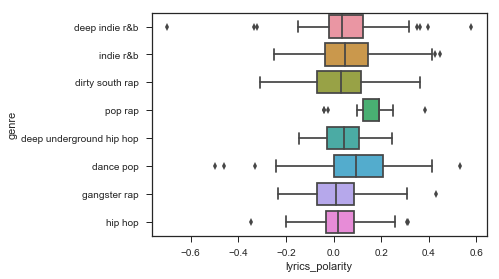

In [57]:
plt_3 = sns.boxplot(y="genre", x='lyrics_polarity', orient="h", data=tsne_df);
plt.subplots_adjust(top=0.9)
# plt_3.savefig("plot_3.png")

In [4]:
try:
    conn = psycopg2.connect("dbname='{0}' user='{1}' password='{2}'".format(db_name, db_user, db_password))
    print("Success connecting to database")
except:
    print("Unable to connect to the database. Check server and credentials.")
    sys.exit(1) # Stop running program if there's no db connection.

# So you can insert by column name
cur = conn.cursor(cursor_factory=psycopg2.extras.RealDictCursor)

## Code to DROP TABLES IF EXIST IN DATABASE (so no repeats).. This will change once the app us up and ready
## as I can use __contains__ to see if the entries already exist or not
cur.execute("DROP TABLE IF EXISTS Songs")
cur.execute("DROP TABLE IF EXISTS Artists")


cur.execute("""CREATE TABLE IF NOT EXISTS Artists(ID SERIAL PRIMARY KEY,
                                                  Name VARCHAR(128),
                                                  Genre VARCHAR(40),
                                                  Popularity INTEGER)""")
cur.execute("""CREATE TABLE IF NOT EXISTS Songs(ID SERIAL PRIMARY KEY,
                                                Name VARCHAR(128),
                                                Track_Number INTEGER,
                                                Artist_Name VARCHAR(128),
                                                Album_Name VARCHAR (128),
                                                Duration_MS FLOAT,
                                                Valence FLOAT,
                                                Energy FLOAT,
                                                Tempo FLOAT,
                                                Speechiness FLOAT,
                                                Danceability FLOAT,
                                                Lyrics TEXT,
                                                Length_Lyrics INTEGER,
                                                Weighted_Sum FLOAT)""")

Success connecting to database


In [15]:
class Table():
    # Class that allows insertion with the database tables

    def __init__(self):
        pass

    def insert_into_artists(self, artist_name, genre, popularity, cur=cur, conn=conn):
            sql = """INSERT INTO Artists(Name, Genre, Popularity) VALUES(%s, %s, %s)"""
            cur.execute(sql, (artist_name, genre, popularity,)) 
        
    def insert_into_songs(self, song_dict, artist_dict, cur=cur, conn=conn):
        """
        Uses the dictionaries containing artist and song info to fill both tables

        Parameters
        -------
        song_dict : dictionary
            Contains song lyrics and length of lyrics for each track
            for each artist
        artist_dict : dictionary
            Contains artist data, and their corresponding albums (and tracks)
        """

        # If either dictionary is empty, raise ValueError
        # so we can scrape artist and song data instead
        if song_dict == {} or artist_dict == {}:
            return ValueError


        sql = """INSERT INTO Songs(Name,
                                   Track_Number,
                                   Artist_Name,
                                   Album_Name,
                                   Duration_MS,
                                   Valence,
                                   Energy,
                                   Tempo,
                                   Speechiness,
                                   Danceability,
                                   Lyrics,
                                   Length_Lyrics)
                                   VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
        # For each key
        for artist in artist_dict:
            if self.__contains__(artist): # if the artist already exists, move on
                # need to find a way to override this in case an artist releases a new album
                # maybe do this for each album instead of each artist?
                # or add an 'override' parameter?
                continue
            # get the artist info and insert into the artist table
            artist_id, genre, artist_popularity, related_artists = artist_dict[artist]['info']
            self.insert_into_artists(artist, genre, artist_popularity)

            for album in artist_dict[artist]['albums']:
                album_title = list(album.keys())[0]
                # loop through this to index in the song dictionary
                for song_id, song_features in album[album_title].items():
                    # This should never cause an exception.. 
                    # TODO: see if I can take this out
                    try:
                        lyrics, len_lyrics = song_dict[artist][song_id]
                    except:
                        lyrics, len_lyrics = "None", 0
                    track_number, track_name, duration_ms, danceability, energy, tempo, speechiness, valence = song_features
                    cur.execute(sql, (track_name, track_number, artist, album_title,
                                      duration_ms, valence, energy, tempo,
                                      speechiness, danceability, lyrics, 
                                      len_lyrics,))  
                print("{} album done for {}".format(album_title, artist))
                conn.commit()
        return True

    def __repr__(self):
        return "This class contains functionality to insert into the songs table"

    def __str__(self):
        # Gets the number of rows in both tables
        sql = """SELECT COUNT(ID) 
                 FROM Songs"""
        cur.execute(sql)
        num_songs = cur.fetchone()
        sql = """SELECT COUNT(ID)
                 FROM Artists"""
        cur.execute(sql)
        num_artists = cur.fetchone()
        return "There are {} songs and {} artists".format(num_songs['count'],
                                                        num_artists['count'])


    def __contains__(self, artist_name):
        sql = """SELECT Name
                 FROM Artists
                 WHERE Name = '{}'""".format(artist_name)
        cur.execute(sql)
        rslt = cur.fetchone()
        if rslt is None:
            return False
        return True

    def get_artists_albums(self, artist_name):
        """
        Queries the Songs table to get album names by that artist

        Parameters
        -------
        artist_name : string
            name of artist to search

        Returns
        -------
        albums : tuple
            Tuple of album names
        """

        sql = """SELECT DISTINCT(Album_Name)
                 FROM Songs
                 WHERE Artist_Name = '{}'""".format(artist_name)
        cur.execute(sql)
        album_list = cur.fetchall()
        # If query returns empty, raise ValueError to trigger scraping of
        # that artist instead
        if album_list == []:
            print(f"Artist {artist_name} does not exist, will get their info.")
            raise ValueError
        albums = [album['album_name'] for album in album_list]
        # convert to tuple so that I can do the query in get_album_songs.
        # It won't work if I keep it as a list
        album_tuple = tuple(albums)
        return album_tuple


    def get_album_songs(self, album_tuple):
        """
        Queries the Songs table to get all rows by each artist in artist_list

        Parameters
        -------
        album_tuple : tuple
            tuple of album names

        Returns
        -------
        albums : tuple
            Tuple of album names
        """
        if len(album_tuple) > 1:
            sql = """SELECT Name, Track_Number, Album_Name,
                     (Duration_MS / 1000 / 60) AS Duration, Valence, Energy,
                     Tempo, Speechiness, Danceability, Length_Lyrics
                     FROM Songs
                     WHERE Album_Name IN {}""".format(album_tuple)
        else:
            sql = """SELECT Name, Track_Number, Album_Name,
                     (Duration_MS / 1000 / 60) AS Duration, Valence, Energy,
                     Tempo, Speechiness, Danceability, Length_Lyrics
                     FROM Songs
                     WHERE Album_Name = '{}' """.format(album_tuple[0])
        cur.execute(sql)
        return cur.fetchall()


In [16]:
table = Table()

In [17]:
artist = 'SZA' # app will get this from user input
table.insert_into_songs(song_dict=songs, artist_dict=artists)
album_list = table.get_artists_albums(artist)

In [21]:
# check to see if contains works
for artist_name in artists:
    assert(artist_name in table)
print('all tests pass')

all tests pass


In [42]:
tsne_df.head()

,artist_x,song_id,lyrics,lyrics_polarity,tsne_x,tsne_y,index,track_num,track_title,track_length,danceability,energy,tempo,speechiness,valence,artist_y,genre,broad_genre
0,Anderson .Paak,4gszZ10tJQXZiI9SxkO4zM,Jokers and Cinderellas at the ball of confusio...,0.283956,0.766219,3.230836,4gszZ10tJQXZiI9SxkO4zM,2,Livvin,165626,0.35,0.765,137.318,0.241,0.267,Anderson .Paak,deep indie r&b,r&b
1,Anderson .Paak,4ecpW3vI1P42ATil2sZCus,Dont do it no favours Night walker youre sham...,-0.036364,-6.326231,10.379881,4ecpW3vI1P42ATil2sZCus,8,Can’t Stop,121133,0.406,0.642,85.844,0.534,0.627,Anderson .Paak,deep indie r&b,r&b
2,Anderson .Paak,6EddQZZdY4yK6oFtFIIGBp,Yes lord yeah Tried to tell niggas in 2012 n...,0.012669,4.184193,-0.255312,6EddQZZdY4yK6oFtFIIGBp,17,Link Up,211093,0.671,0.814,100.019,0.273,0.515,Anderson .Paak,deep indie r&b,r&b
3,Anderson .Paak,44rP6oQL3TpqECCK3OOlg1,If you wonder how I do In the right place Wit...,-0.054432,-2.106955,1.970045,44rP6oQL3TpqECCK3OOlg1,18,Another Time,147573,0.55,0.66,88.004,0.075,0.796,Anderson .Paak,deep indie r&b,r&b
4,Anderson .Paak,5wWbp6br0ziiy6OZ9iPVz6,A bird with the word came to me The sweetness...,0.090625,4.487449,9.840529,5wWbp6br0ziiy6OZ9iPVz6,1,The Bird,225503,0.508,0.556,149.474,0.448,0.64,Anderson .Paak,deep indie r&b,r&b


,artist,song_id,lyrics
0,Anderson .Paak,4gszZ10tJQXZiI9SxkO4zM,Jokers and Cinderellas at the ball of confusio...
0,Anderson .Paak,4ecpW3vI1P42ATil2sZCus,Dont do it no favours Night walker youre sham...
0,Anderson .Paak,6EddQZZdY4yK6oFtFIIGBp,Yes lord yeah Tried to tell niggas in 2012 n...
0,Anderson .Paak,44rP6oQL3TpqECCK3OOlg1,If you wonder how I do In the right place Wit...
0,Anderson .Paak,5wWbp6br0ziiy6OZ9iPVz6,A bird with the word came to me The sweetness...
0,Anderson .Paak,2WizYk0YTQtap38SPYImqB,Ooh champagne pourin down Arms legs wrapped a...
0,Anderson .Paak,5VeJ6TMOv4T4pIGv5TY1hd,Yes lord yeah Tried to tell niggas in 2012 n...
0,Anderson .Paak,4JfEtJUQGO6nl7lzfAmHyo,My faith is buried somewhere underneath the...
0,Anderson .Paak,3Hn7FUkvciiwbnxQTUMyjf,Why the hell would you run this game Both my ...
0,Anderson .Paak,2kDL9xAqKwvbLvB0SzPOQL,Well I Well I yeah Im only comin out to play...
